In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.interpolate import interp1d

# write a normalized pdf for event-rates distribution
from astropy.cosmology import LambdaCDM
cosmo = LambdaCDM(H0=70, Om0=0.3, Ode0=0.7)

## Defining required functions

In [29]:

def d_comoving_volume(zs):
	"""Function to calculate the differential comoving volume element at redshift z.

	Parameters
	----------
	zs : float or array_like
		Redshift

	Returns
	-------
	float or array_like
		Differential comoving volume element at redshift z

	"""

	return 4*np.pi*cosmo.differential_comoving_volume(zs).value
	
def merger_rate_density(
        zs, R0=23.9 * 1e-9, b2=1.6, b3=2.0, b4=30,
    ):
    """Function to compute the merger rate density (PopI/PopII). Reference: Oguri et al. (2018). The output is in detector frame and is unnormalized.

    Parameters
    ----------
    zs : `float` or `numpy.ndarray` (nD array of floats)
        Source redshifts
    R0 : `float`
        local merger rate density at low redshift
        default: 23.9*1e-9 Mpc^-3 yr^-1
    b2 : `float`
        Fitting paramters
        default: 1.6
    b3 : `float`
        Fitting paramters
        default: 2.0
    b4 : `float`
        Fitting paramters
        default: 30

    Returns
    ----------
    rate_density : `float` or `numpy.ndarray` (nD array of floats)
        merger rate density

    Examples
    ----------
    >>> rate_density = merger_rate_density_bbh_popI_II_oguri2018(zs=0.1)
    """
    
    return R0 * (b4 + 1) * np.exp(b2 * zs) / (b4 + np.exp(b3 * zs)) #

def pdf_event_rate(zs):
	"""Function to calculate the probability density function of event rate at redshift z.

	Parameters
	----------
	zs : float or array_like
		Redshift

	Returns
	-------
	float or array_like
		Probability density function of event rate at redshift z

	"""
	return d_comoving_volume(zs) * merger_rate_density(zs) / (1 + zs)
	

## What is the BBH total merger rate regardless of detection?

In [31]:
# units: Mpc^-3 yr^-1 
quad(pdf_event_rate, 0, z_max)[0]

103522.89660721329

## Constructing sampling function for $z_s$

### Rejection sampling

In [33]:
z_max = 10
normalization = quad(pdf_event_rate, 0, z_max)[0]

# Probability density function of event rate at redshift z
def pdf_z(zs):
	return pdf_event_rate(zs) / normalization

In [35]:
def rejection_sampling(size, pdf, xmin, xmax):
    """
    Function to generate random samples from a normal distribution using the rejection sampling method

    Parameters
    ----------
    size : int
        The number of samples to generate
    pdf : function
        The probability density function of the normal distribution
    xmin : float
        The minimum value of the range to sample from
    xmax : float
        The maximum value of the range to sample from

    Returns
    -------
    array-like
        The generated samples
    """

    x = np.linspace(xmin, xmax, 1000)
    y = pdf(x)
    ymax = np.max(y) # Maximum value of the pdf
    x_samples = []
    while len(x_samples) < size:
        x_try = np.random.uniform(xmin, xmax, size=size)
        pdf_y_try = pdf(x_try)
        # this is for comparing with the pdf value at x_try, will be used to accept or reject the sample
        y_try = np.random.uniform(0, ymax, size=size) 
    
        # Update the maximum value of the pdf
        ymax = max(ymax, np.max(pdf_y_try))  
        
        # applying condition to accept the sample
        accepted = list(x_try[y_try < pdf_y_try]) 
        # add to the list
        x_samples += accepted

    return np.array(x_samples[:size]) # this also trims to the correct size

In [38]:
new_zs = rejection_sampling(size=10000, pdf=pdf_z, xmin=0, xmax=z_max)

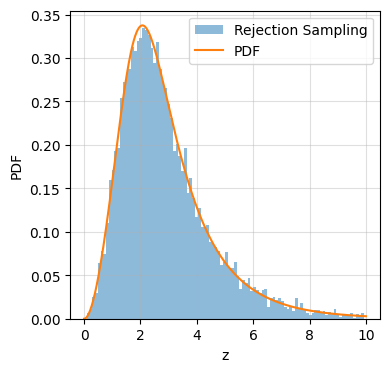

In [45]:
plt.figure(figsize=(4, 4))
x = np.linspace(0, z_max, 1000)
plt.hist(new_zs, bins=100, density=True, alpha=0.5, label='Rejection Sampling')
plt.plot(x, pdf_z(x), label='PDF')
plt.xlabel('z')
plt.ylabel('PDF')
plt.legend()
plt.grid(alpha=0.4)
plt.show()

In [37]:
# Cumulative distribution function of event rate at redshift z
def cdf_z(zs):

	if type(zs) == np.ndarray:

		cdf = np.zeros(len(zs))
		for i, z in enumerate(zs):
			cdf[i] = quad(pdf_z, 0, z)[0]
	elif type(zs) == float:
		cdf = quad(pdf_z, 0, zs)[0]
	else:
		raise ValueError("zs should be either a float or a numpy array")

	return cdf